# Create model from scratch

In [1]:
# Import RPB model along with other utility functions

from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Product
from RPB_model import RotaryPackedBed

from pyomo.environ import (
    ConcreteModel,
    SolverFactory,
    TransformationFactory,
    Reference,
    units as pyunits,
    Param,
)

import idaes.core.util as iutil
import idaes.core.util.scaling as iscale
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.logger as idaeslog
from idaes.core.util.initialization import propagate_state

from idaes.models_extra.power_generation.properties import FlueGasParameterBlock
from idaes.models.properties.modular_properties.base.generic_property import (
    GenericParameterBlock,
)
from idaes.models_extra.power_generation.properties.natural_gas_PR import (
    get_prop,
    EosType,
)

from pyomo.network import Arc

from idaes.core.util.model_diagnostics import DiagnosticsToolbox

import numpy as np

In [2]:
# create Flowsheet block

m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic = False)

In [3]:
# create gas phase properties block
flue_species={"H2O", "CO2", "N2"}
prop_config = get_prop(flue_species, ["Vap"], eos=EosType.IDEAL)
prop_config["state_bounds"]["pressure"] = (0.99*1e5,1.02*1e5,1.2*1e5, pyunits.Pa)
prop_config["state_bounds"]["temperature"] = (25+273.15,90+273.15,180+273.15, pyunits.K)

m.fs.gas_props = GenericParameterBlock(
    **prop_config,
    doc = "Flue gas properties",
)

m.fs.gas_props.set_default_scaling("temperature", 1e-2)
m.fs.gas_props.set_default_scaling("pressure", 1e-4)

In [4]:
# create feed and product blocks

m.fs.flue_gas_in = Feed(property_package = m.fs.gas_props)
m.fs.flue_gas_out = Product(property_package = m.fs.gas_props)
m.fs.steam_sweep_feed = Feed(property_package = m.fs.gas_props)
m.fs.regeneration_prod = Product(property_package = m.fs.gas_props)

In [5]:
# increased number of discretization points, lower mass balance error

# z_init_points=tuple(np.geomspace(0.01, 0.5, 9)[:-1]) + tuple((1 - np.geomspace(0.01, 0.5, 9))[::-1])
# o_init_points=tuple(np.geomspace(0.005, 0.1, 8)) + tuple(np.linspace(0.1, 0.995, 10)[1:])

# z_nfe=20
# o_nfe=20

# m.fs.RPB = RotaryPackedBed(
#     property_package = m.fs.gas_props,
#     z_init_points=z_init_points,
#     o_init_points=o_init_points,
#     z_nfe=z_nfe,
#     o_nfe=o_nfe,
# )

In [6]:
# limited discretization, much faster

m.fs.RPB = RotaryPackedBed(
    property_package = m.fs.gas_props,
    z_init_points = (0.01,0.99),
    o_init_points = (0.01,0.99),
)

In [7]:
# add stream connections

m.fs.s_flue_gas = Arc(source=m.fs.flue_gas_in.outlet, destination=m.fs.RPB.ads_gas_inlet)
m.fs.s_cleaned_flue_gas = Arc(source=m.fs.RPB.ads_gas_outlet, destination=m.fs.flue_gas_out.inlet)
m.fs.s_steam_feed = Arc(source=m.fs.steam_sweep_feed.outlet, destination=m.fs.RPB.des_gas_inlet)
m.fs.s_regeneration_prod = Arc(source=m.fs.RPB.des_gas_outlet, destination=m.fs.regeneration_prod.inlet)

TransformationFactory("network.expand_arcs").apply_to(m)

In [8]:
# fix state variables in feed and product blocks
# ads side
m.fs.flue_gas_in.pressure.fix(1.02*1e5)
m.fs.flue_gas_in.temperature.fix(90+273.15)
m.fs.flue_gas_out.pressure.fix(1.01325*1e5)
m.fs.flue_gas_in.mole_frac_comp[0,"CO2"].fix(0.04)
m.fs.flue_gas_in.mole_frac_comp[0,"H2O"].fix(0.09)
m.fs.flue_gas_in.mole_frac_comp[0,"N2"].fix(1-0.04-0.09)

#des side
m.fs.steam_sweep_feed.pressure.fix(1.05*1e5)
m.fs.steam_sweep_feed.temperature.fix(120+273.15)
m.fs.regeneration_prod.pressure.fix(1.01325*1e5)
m.fs.steam_sweep_feed.mole_frac_comp[0,"CO2"].fix(1e-5)
m.fs.steam_sweep_feed.mole_frac_comp[0,"N2"].fix(1e-3)
m.fs.steam_sweep_feed.mole_frac_comp[0,"H2O"].fix(1-1e-5-1e-3)

In [9]:
# fix design variables of the RPB

m.fs.RPB.ads.Tx.fix()
m.fs.RPB.des.Tx.fix()

m.fs.RPB.w_rpm.fix(0.1)

In [10]:
# check degrees of freedom

print("DOF =",degrees_of_freedom(m))

DOF = 0


In [11]:
# initialize feed and product blocks

m.fs.flue_gas_in.initialize()
m.fs.flue_gas_out.initialize()
m.fs.steam_sweep_feed.initialize()
m.fs.regeneration_prod.initialize()

2025-05-08 07:56:40 [INFO] idaes.init.fs.flue_gas_in.properties: Starting initialization
2025-05-08 07:56:40 [INFO] idaes.init.fs.flue_gas_in.properties: Property initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:40 [INFO] idaes.init.fs.flue_gas_in.properties: Property package initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:40 [INFO] idaes.init.fs.flue_gas_in: Initialization Complete.
2025-05-08 07:56:40 [INFO] idaes.init.fs.flue_gas_out.properties: Starting initialization
2025-05-08 07:56:41 [INFO] idaes.init.fs.flue_gas_out.properties: Property initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:41 [INFO] idaes.init.fs.flue_gas_out.properties: Property package initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:41 [INFO] idaes.init.fs.flue_gas_out: Initialization Complete.
2025-05-08 07:56:41 [INFO] idaes.init.fs.steam_sweep_feed.properties: Starting initialization
2025-05-08 07:56:41 [INFO] idaes.init.fs.steam_sweep_f

In [12]:
# propagate feed and product blocks (for initial RPB guesses)
propagate_state(arc = m.fs.s_flue_gas, direction="forward")
propagate_state(arc = m.fs.s_steam_feed, direction="forward")
propagate_state(arc = m.fs.s_cleaned_flue_gas, direction="backward")
propagate_state(arc = m.fs.s_regeneration_prod, direction="backward")

In [13]:
# Initialize RPB (about 4 mins for smaller discretization size and close to 20 mins for the larger size)

optarg = {
    # "halt_on_ampl_error": "yes",
    "max_iter": 1000,
    "bound_push": 1e-22,
    # "mu_init": 1e-3,
    "nlp_scaling_method": "user-scaling",
}

init_points = [1e-5,1e-3,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

m.fs.RPB.initialize(outlvl=idaeslog.INFO, optarg=optarg, initialization_points=init_points)

2025-05-08 07:56:41 [INFO] idaes.init.fs.RPB: Beginning Initialization
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.inlet_properties: Starting initialization
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.inlet_properties: State variable initialization completed.
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.inlet_properties: Property initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.inlet_properties: Property package initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.outlet_properties: Starting initialization
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.outlet_properties: State variable initialization completed.
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.outlet_properties: Property initialization: optimal - Optimal Solution Found.
2025-05-08 07:56:44 [INFO] idaes.init.fs.RPB.ads.outlet_properties: Property package initialization: optimal - Optimal Solution Found.
2025-05

In [14]:
# full solve with IPOPT

Solver = SolverFactory("ipopt")
Solver.solve(m, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    con

In [15]:
# can skip the initialization steps and load an already saved model then solve

# if using the smaller discretization
iutil.from_json(m, fname="RPB flowsheet 081924, limited disc.json.gz", gz=True)
# if using the larger discretization
# iutil.from_json(m, fname="RPB flowsheet 081924.json.gz", gz=True)

Solver = SolverFactory("ipopt")
Solver.solve(m, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    con

In [16]:
m.fs.report(dof=True)


Flowsheet : fs                                                             Time: 0.0
    Local Degrees of Freedom: 0
    Total Variables: 7504    Activated Constraints: 7023    Activated Blocks: 267
------------------------------------------------------------------------------------
    Stream Table
                                Units       s_flue_gas  s_cleaned_flue_gas  s_steam_feed  s_regeneration_prod
    Total Molar Flowrate     mole / second      80.176          77.114           168.43           173.00     
    Total Mole Fraction H2O  dimensionless    0.090000        0.093574          0.99899          0.97260     
    Total Mole Fraction N2   dimensionless     0.87000         0.90455        0.0010000       0.00097358     
    Total Mole Fraction CO2  dimensionless    0.040000       0.0018765       1.0000e-05         0.026429     
    Temperature                     kelvin      363.15          391.38           393.15           363.66     
    Pressure                        pa

In [17]:
m.fs.RPB.report(dof=True)


Unit : fs.RPB                                                              Time: 0.0
    Local Degrees of Freedom: 12
    Total Variables: 7415    Activated Constraints: 6979    Activated Blocks: 249
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value    : Units           : Fixed : Bounds
                 Adsorption Tx :   363.00 :          kelvin :  True : (0, None)
    Adsorption Volume Fraction :  0.75000 :   dimensionless :  True : (0.01, 0.99)
                   CO2 Capture :  0.95488 :   dimensionless : False : (None, None)
                 Desorption Tx :   393.00 :          kelvin :  True : (0, None)
    Desorption Volume Fraction :  0.25000 :   dimensionless : False : (0.01, 0.99)
                      Diameter :   10.000 :           meter :  True : (0, None)
                        Length :   3.0000 :           meter :  True : (0.1, 10.001)
           Rotational Vel

# Diagnostics testing

In [18]:
diagtool = DiagnosticsToolbox(m)

In [19]:
diagtool.display_constraints_with_extreme_jacobians()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
The following constraint(s) are associated with extreme Jacobian values (<1.0E-04 or>1.0E+04):

    fs.RPB.des.CO2_capture_eq[0.0]: 4.572E+05
    fs.RPB.ads.bc_P_in[0.0,0]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.01]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.1325]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.255]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.3775]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.5]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.6225]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.745]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.8675]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,0.99]: 1.414E-05
    fs.RPB.ads.bc_P_in[0.0,1]: 1.414E-05
    fs.RPB.ads.bc_P_out[0.0,0]: 1.414E-05
    fs.RPB.ads.bc_P_out[0.0,0.01]: 1.414E-05
    fs.RPB.ads.bc_P_out[0.0,0.1325]: 1.414E-05
    fs.RPB.ads.bc_P_out[0.0,0.255]: 1.414E-05
    fs.RPB.ads.bc_P_out[0.0,0.3775]: 1.414E-05
    fs

In [20]:
diagtool.display_variables_with_extreme_jacobians()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
The following variable(s) are associated with extreme Jacobian values (<1.0E-04 or>1.0E+04):

    fs.RPB.des.inlet_properties[0.0].mole_frac_comp[CO2]: 4.572E+05



In [21]:
diagtool.report_numerical_issues()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Model Statistics

    Jacobian Condition Number: 1.242E+14

------------------------------------------------------------------------------------
0 WARNINGS

    No warnings found!

------------------------------------------------------------------------------------
9 Cautions

    Caution: 610 Variables with value close to their bounds (abs=1.0E-04, rel=1.0E-04)
    Caution: 996 Variables with value close to zero (tol=1.0E-08)
    Caution: 339 Variables with extreme value (<1.0E-04 or >1.0E+04)
    Caution: 154 Variables with None value
    Caution: 662 Constraints with mismatched terms
    Caution: 494 Constraints with potential cancellation of terms
    Caution: 1 Variable with extreme Jacobian values (<1.0E-04 or >1.0E+04)
    Caution: 45 Constraints with extreme Jacobian values (<1.0E-04 or >1.0E+04)
    Caution: 2980 extreme Jacobian Entries (<1

In [22]:
diagtool.display_variables_with_extreme_values()

The following variable(s) have extreme values (<1.0E-04 or > 1.0E+04):

    fs.gas_props.H2O.pressure_crit: 22120000.0
    fs.gas_props.N2.pressure_crit: 3390000.0
    fs.gas_props.CO2.pressure_crit: 7380000.0
    fs.flue_gas_in.properties[0.0].pressure: 102000.0
    fs.flue_gas_out.properties[0.0].pressure: 101325.0
    fs.steam_sweep_feed.properties[0.0].mole_frac_comp[CO2]: 1e-05
    fs.steam_sweep_feed.properties[0.0].pressure: 105000.0
    fs.steam_sweep_feed.properties[0.0].mole_frac_phase_comp[Vap,CO2]: 1e-05
    fs.regeneration_prod.properties[0.0].pressure: 101325.0
    fs.RPB.ads.inlet_properties[0.0].pressure: 102000.0
    fs.RPB.ads.outlet_properties[0.0].pressure: 101325.0
    fs.RPB.des.inlet_properties[0.0].mole_frac_comp[CO2]: 1e-05
    fs.RPB.des.inlet_properties[0.0].pressure: 105000.0
    fs.RPB.des.outlet_properties[0.0].pressure: 101325.0
    fs.RPB.ads.gas_properties[0.0,0,0].pressure: 102000.0
    fs.RPB.ads.gas_properties[0.0,0,0.01].pressure: 102000.0
    fs.RP

In [23]:
diagtool.report_structural_issues()

Model Statistics

        Activated Blocks: 268 (Deactivated: 0)
        Free Variables in Activated Constraints: 7023 (External: 0)
            Free Variables with only lower bounds: 272
            Free Variables with only upper bounds: 0
            Free Variables with upper and lower bounds: 3999
        Fixed Variables in Activated Constraints: 306 (External: 0)
        Activated Equality Constraints: 7023 (Deactivated: 0)
        Activated Inequality Constraints: 0 (Deactivated: 0)
        Activated Objectives: 0 (Deactivated: 0)

------------------------------------------------------------------------------------
1 WARNINGS


------------------------------------------------------------------------------------
2 Cautions

    Caution: 1 variable fixed to 0
    Caution: 175 unused variables (21 fixed)

------------------------------------------------------------------------------------
Suggested next steps:

    display_potential_evaluation_errors()



In [24]:
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)

    # print("Extreme Jacobian entries:")
    with open("extreme_jacobian_entries.txt", "w") as f:
        for i in iscale.extreme_jacobian_entries(
            jac=jac, nlp=nlp, small=1e-4, large=1e4
        ):
            print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]", file=f)

    # print("Extreme Jacobian Columns:")
    with open("extreme_jacobian_columns.txt", "w") as f:
        for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, small=1e-3, large=1e3
        ):
            print(f"    {i[0]:.2e}, [{i[1]}]", file=f)

    # print("Extreme Jacobian Rows:")
    with open("extreme_jacobian_rows.txt", "w") as f:
        for i in iscale.extreme_jacobian_rows(jac=jac, nlp=nlp, small=1e-3, large=1e3):
            print(f"    {i[0]:.2e}, [{i[1]}]", file=f)

    with open("badly_scaled_vars.txt", "w") as f:
        for v, sv in iscale.badly_scaled_var_generator(
            blk, large=1e4, small=1e-4, zero=1e-12
        ):
            print(f"    {v} -- {sv} -- {iscale.get_scaling_factor(v)}", file=f)

    print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

check_scaling(m)

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Jacobian Condition Number: 1.02e+13


# Plotting

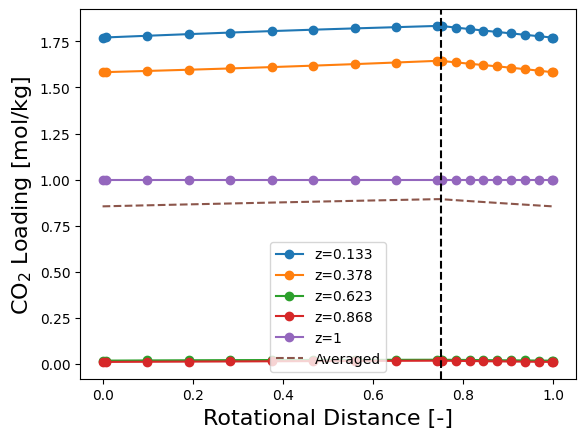

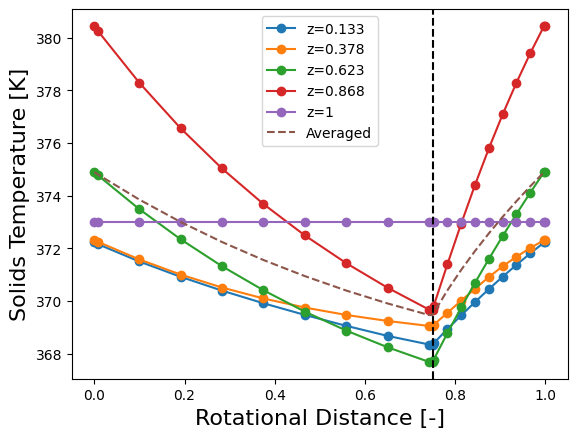

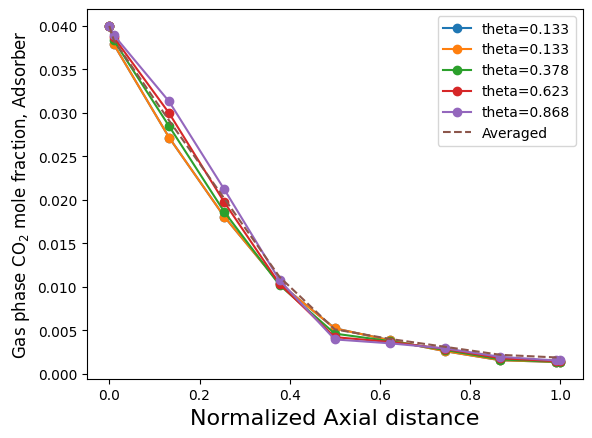

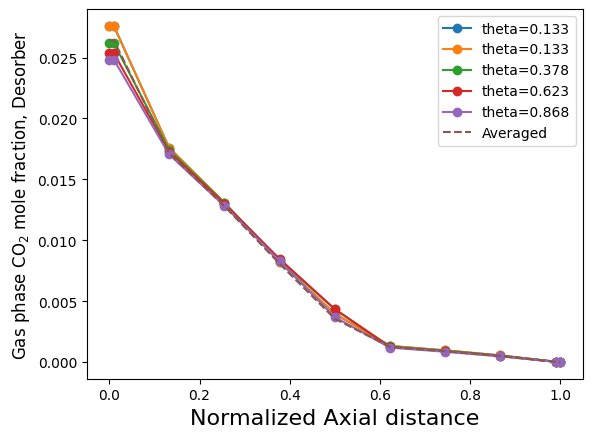

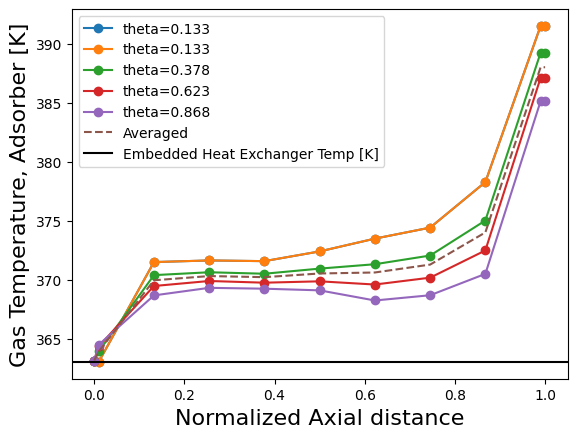

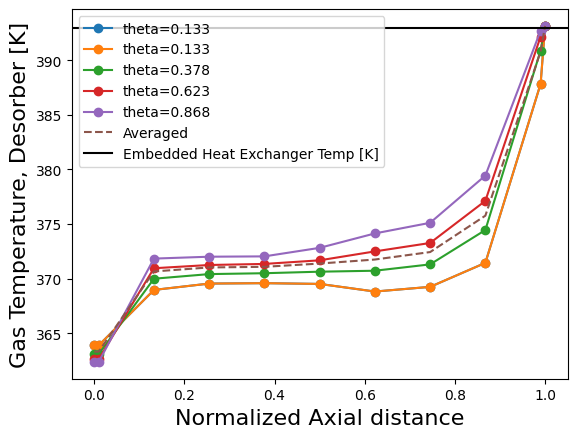

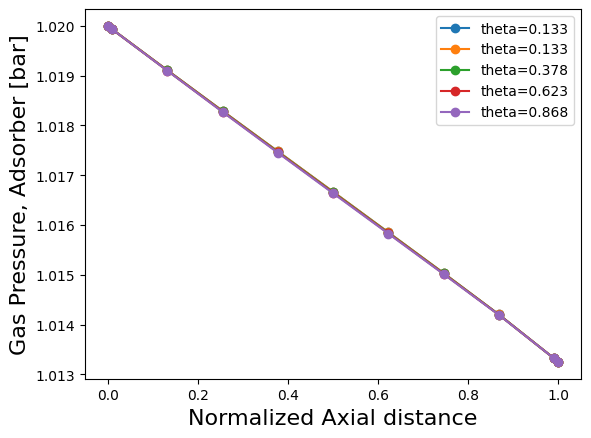

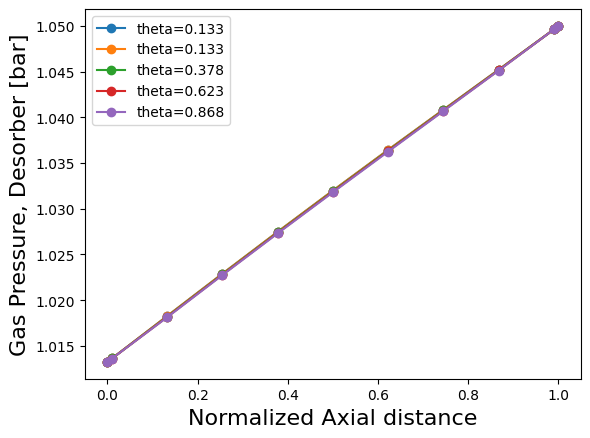

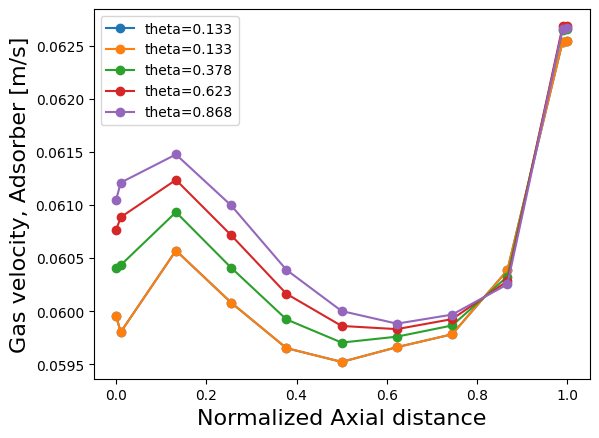

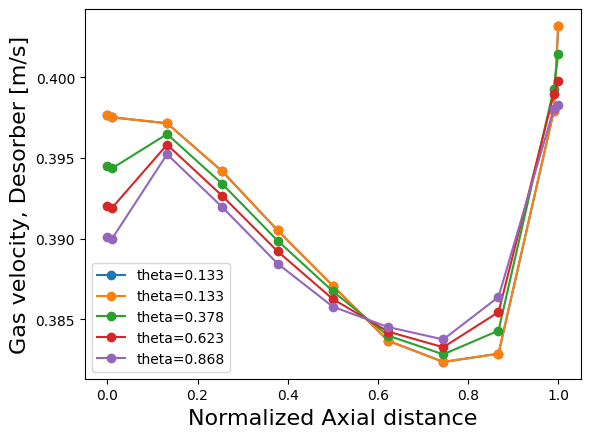

In [25]:
m.fs.RPB.plotting()

# Optimization

In [26]:
# add objective function
# create regularization parameter for the objective function
m.fs.RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@m.fs.RPB.Objective()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement[0] - (1 - RPB.alpha_obj) * RPB.productivity[0]

m.fs.RPB.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 24.65688487998521


In [27]:
# fix capture and free up inlet ads pressure
m.fs.RPB.ads.CO2_capture.fix(0.95)

m.fs.flue_gas_in.pressure.unfix()

In [28]:
# solve for fixed capture
solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
    "nlp_scaling_method": "user-scaling",
}
solver.solve(m, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: max_iter=1000
bound_push=1e-22
halt_on_ampl_error=yes
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales an

In [29]:
m.fs.RPB.report()


Unit : fs.RPB                                                              Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value    : Units           : Fixed : Bounds
                 Adsorption Tx :   363.00 :          kelvin :  True : (0, None)
    Adsorption Volume Fraction :  0.75000 :   dimensionless :  True : (0.01, 0.99)
                   CO2 Capture :  0.95000 :   dimensionless :  True : (None, None)
                 Desorption Tx :   393.00 :          kelvin :  True : (0, None)
    Desorption Volume Fraction :  0.25000 :   dimensionless : False : (0.01, 0.99)
                      Diameter :   10.000 :           meter :  True : (0, None)
                        Length :   3.0000 :           meter :  True : (0.1, 10.001)
           Rotational Velocity : 0.010472 : radian / second :  True : (1e-05, 2)

    Expressions: 

    Key                : Value      : U

In [30]:
# set bounds for decision variables
m.fs.RPB.L.setlb(0.1)
m.fs.RPB.L.setub(20)
m.fs.RPB.L.pprint()

L : Bed Length [m]
    Size=1, Index=None, Units=m
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :   0.1 :     3 :    20 :  True :  True : PositiveReals


In [31]:
m.fs.RPB.ads.Tx.setlb(25+273)
m.fs.RPB.ads.Tx.setub(95+273)
m.fs.RPB.ads.Tx.pprint()

Tx : heat exchange fluid temperature, constant [K]
    Size=1, Index=fs._time, Units=K
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 :   298 :   363 :   368 :  True :  True : PositiveReals


In [32]:
m.fs.RPB.des.Tx.setlb(100+273)
m.fs.RPB.des.Tx.setub(160+273)
m.fs.RPB.des.Tx.pprint()

Tx : heat exchange fluid temperature, constant [K]
    Size=1, Index=fs._time, Units=K
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 :   373 :   393 :   433 :  True :  True : PositiveReals


In [33]:
m.fs.flue_gas_in.pressure.setub(1.2*1e5)
m.fs.flue_gas_in.pressure.setlb(1.0001*1e5)
m.fs.flue_gas_in.pressure.pprint()

pressure : Size=1, Index=fs._time, ReferenceTo=fs.flue_gas_in.properties[:].component('pressure')
    Key : Lower    : Value             : Upper    : Fixed : Stale : Domain
    0.0 : 100010.0 : 102032.4862563451 : 120000.0 : False : False : NonNegativeReals


In [34]:
m.fs.steam_sweep_feed.pressure.setub(1.2*1e5)
m.fs.steam_sweep_feed.pressure.setlb(1.0001*1e5)
m.fs.steam_sweep_feed.pressure.pprint()

pressure : Size=1, Index=fs._time, ReferenceTo=fs.steam_sweep_feed.properties[:].component('pressure')
    Key : Lower    : Value    : Upper    : Fixed : Stale : Domain
    0.0 : 100010.0 : 105000.0 : 120000.0 :  True :  True : NonNegativeReals


In [35]:
m.fs.RPB.w_rpm.setlb(0.00001)
m.fs.RPB.w_rpm.setub(0.01)
m.fs.RPB.w_rpm.pprint()

w_rpm : bed rotational speed [revolutions/min]
    Size=1, Index=fs._time, Units=turn/min
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 : 1e-05 :   0.1 :  0.01 :  True :  True : PositiveReals


In [36]:
m.fs.RPB.ads.theta.setub(0.95)
m.fs.RPB.ads.theta.pprint()

theta : Fraction of bed occupied by the section[-]
    Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :  0.01 :  0.75 :  0.95 :  True :  True : PositiveReals


In [37]:
# free up optimization variables
m.fs.RPB.L.unfix()
m.fs.RPB.ads.theta.unfix()
m.fs.steam_sweep_feed.pressure.unfix()
m.fs.RPB.ads.Tx.unfix()
m.fs.RPB.des.Tx.unfix()
m.fs.RPB.w_rpm.unfix()

In [38]:
solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
    "nlp_scaling_method": "user-scaling",
}
solver.solve(m, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: max_iter=1000
bound_push=1e-22
halt_on_ampl_error=yes
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales an

In [39]:
# solve using conopt thorugh gams (usually works better than IPOPT)
results = SolverFactory("gams").solve(
    m,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

NameError: No 'gams' command found on system PATH - GAMS shell solver functionality is not available.

In [40]:
m.fs.RPB.report()
m.fs.RPB.energy_requirement.display()
m.fs.RPB.productivity.display()


Unit : fs.RPB                                                              Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value      : Units           : Fixed : Bounds
                 Adsorption Tx :     359.04 :          kelvin : False : (298, 368)
    Adsorption Volume Fraction :    0.94707 :   dimensionless : False : (0.01, 0.95)
                   CO2 Capture :    0.95000 :   dimensionless :  True : (None, None)
                 Desorption Tx :     431.55 :          kelvin : False : (373, 433)
    Desorption Volume Fraction :   0.052933 :   dimensionless : False : (0.01, 0.99)
                      Diameter :     10.000 :           meter :  True : (0, None)
                        Length :     14.756 :           meter : False : (0.1, 20)
           Rotational Velocity : 5.4265e-05 : radian / second : False : (1e-05, 0.01)

    Expressions: 

    Key             

In [41]:
diagtool = DiagnosticsToolbox(m)

In [42]:
diagtool.config.variable_bounds_absolute_tolerance = 1e-6
diagtool.config.variable_bounds_relative_tolerance = 1e-6

In [43]:
diagtool.display_variables_near_bounds()

The following variable(s) have values close to their bounds (abs=1.0E-06, rel=1.0E-06):




pareto front generation (hasn't been updated for the IDAES model version)

In [82]:
for t in m.fs.time:
    m.fs.RPB.ads.F_in[t].pprint()
    print(m.fs.RPB.ads.inlet_properties[t].flow_mol.value)
    print(m.fs.RPB.ads.flow_mol_inlet[t].value)
    print(m.fs.RPB.ads.vel[t, 0, 0].value)
    m.fs.RPB.des.F_in[t].pprint()
    print(m.fs.RPB.des.inlet_properties[t].flow_mol.value)
    print(m.fs.RPB.des.vel[t, 0, 0].value)
    print(m.fs.RPB.w_rpm[t].value)

m.fs.RPB.C1.pprint()

{Member of F_in} : Inlet adsorber gas flow [mol/s]
    Size=1, Index=fs._time
    Key : Expression
    0.0 : fs.RPB.ads.inlet_properties[0.0].flow_mol
134.22814814228332
134.22814814228332
0.07746295928815877
{Member of F_in} : Inlet adsorber gas flow [mol/s]
    Size=1, Index=fs._time
    Key : Expression
    0.0 : fs.RPB.des.inlet_properties[0.0].flow_mol
12.380438709806889
0.1700992051892952
0.0005181971588844665
C1 : lumped MT parameter [m^2/K^0.5/s]
    Size=1, Index=None, Domain=Any, Default=None, Mutable=True, Units=m**2/K**0.5/s
    Key  : Value
    None : 2.562434e-12


In [ ]:
# # list of alpha values to use in the objective function
# alpha_list=[
#     0.0001,
#     0.001,
#     0.005,
#     0.01,
#     0.02,
#     0.05,
#     0.1,
#     0.2,
#     0.3,
#     0.4,
#     0.5,
#     0.6,
#     0.7,
#     0.8,
#     0.9,
#     0.925,
#     0.95,
#     0.975,
#     0.99,
#     0.999,
# ]

In [ ]:
# # optimize for every value and store the results
# E = []
# P = []

# for j in alpha_list:
#     RPB.alpha_obj = j

#     results = SolverFactory("gams").solve(
#         RPB,
#         tee=True,
#         keepfiles=True,
#         solver="conopt4",
#         tmpdir="temp",
#         add_options=["gams_model.optfile=1;"],
#     )

#     print(f'alpha = {j}, E={RPB.energy_requirement()}, P={RPB.productivity()}')

#     E.append(RPB.energy_requirement())
#     P.append(RPB.productivity())


In [ ]:
# pd.DataFrame({'alpha':alpha_list,'E':E,'P':P})

In [ ]:
# plt.scatter(E,P)

# Polishing step simulation and optimization (hasn't been updated for the IDAES model version)

start from previous optimized case

In [ ]:
# create pyomo model
# RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [ ]:
# # create regularization parameter for the objective function
# RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# # add objective
# @RPB.Expression()
# def obj(RPB):
#     return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

# RPB.objective = Objective(expr=RPB.obj)

# RPB.objective.pprint()

In [ ]:
# # set bounds for decision variables
# RPB.ads.L.setlb(0.01)
# RPB.ads.L.setub(40)
# RPB.des.L.setlb(0.01)
# RPB.des.L.setub(40)
# RPB.ads.L.pprint()

In [ ]:
# RPB.ads.Tx.setlb(25+273)
# RPB.ads.Tx.setub(95+273)
# RPB.ads.Tx.pprint()

In [ ]:
# RPB.des.Tx.setlb(100+273)
# RPB.des.Tx.setub(160+273)
# RPB.des.Tx.pprint()

In [ ]:
# RPB.ads.P_in.setub(1.5)
# RPB.ads.P_in.pprint()
# RPB.ads.P.setub(1.5)

In [ ]:
# RPB.des.P_in.setub(1.5)
# RPB.des.P_in.setlb(1.01325)
# RPB.des.P.setub(1.5)
# RPB.des.P_in.pprint()

In [ ]:
# RPB.ads.w_rpm.setlb(0.00001)
# RPB.ads.w_rpm.setub(0.1)
# RPB.ads.w_rpm.pprint()

In [ ]:
# # load a previous solution and solve (will also load the inlet gas feed conc.)
# from_json(RPB, fname="polishing step optimized solution 031824.json.gz", gz=True)

In [ ]:
# # solve using conopt thorugh gams
# results = SolverFactory("gams").solve(
#     RPB,
#     tee=True,
#     keepfiles=True,
#     solver="conopt4",
#     tmpdir="temp",
#     add_options=["gams_model.optfile=1;"],
# )

# Save Model

In [ ]:
# save model
iutil.to_json(m, fname="base case solution 012424.json.gz", gz=True, human_read=False)